In [1]:
from Video import Video

In [2]:
%%time
video_path = 'examples/videos/male/id2_vcd_swwp2s.mpg'
video = Video(video_path, efficient=False)

CPU times: user 4.86 s, sys: 141 ms, total: 5 s
Wall time: 3.88 s


In [3]:
%%time
video_path = 'examples/videos/male/id2_vcd_swwp2s.mpg'
video = Video(video_path, efficient=True)

CPU times: user 4.68 s, sys: 161 ms, total: 4.84 s
Wall time: 3.73 s


In [4]:
video

frames shape: (75, 288, 360)
mouth frames: 75, frame shape: (50, 80)

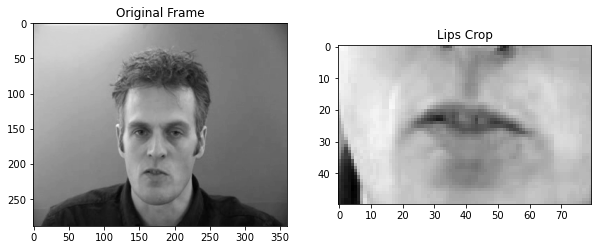

In [5]:
video.plot_random_lips()

# 68 Face Landmarks:

In [6]:
import dlib
import numpy as np
import matplotlib.pyplot as plt

In [7]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('./facial-landmarks-models/shape_predictor_68_face_landmarks.dat')
video_path = 'examples/videos/male/id2_vcd_swwp2s.mpg'

In [8]:
frame = video.frames[0]

In [9]:
def face_landmarks_scatter(points, c, s):
    plt.scatter(points[:,0], points[:,1], c=c, s=[s]*len(points))

In [10]:
def get_face(image):
    rects = detector(image,1)
    shape = predictor(image, rects[0])
    face_points = []
    for part in shape.parts():
        face_points.append((part.x, part.y))
    np_face_points = np.array(face_points)
    nose = np_face_points[28:36]
    left_eye = np_face_points[36:42]
    right_eye = np_face_points[42:48]
    lips = np_face_points[48:]
    dot_size = 8
    ax = plt.figure(figsize=(12,12))
    plt.imshow(image, cmap='gray')
    face_points = [nose, left_eye, right_eye, lips]
    for points in face_points:
        face_landmarks_scatter(points, c='royalblue', s=dot_size)
    plt.show()
    return face_points

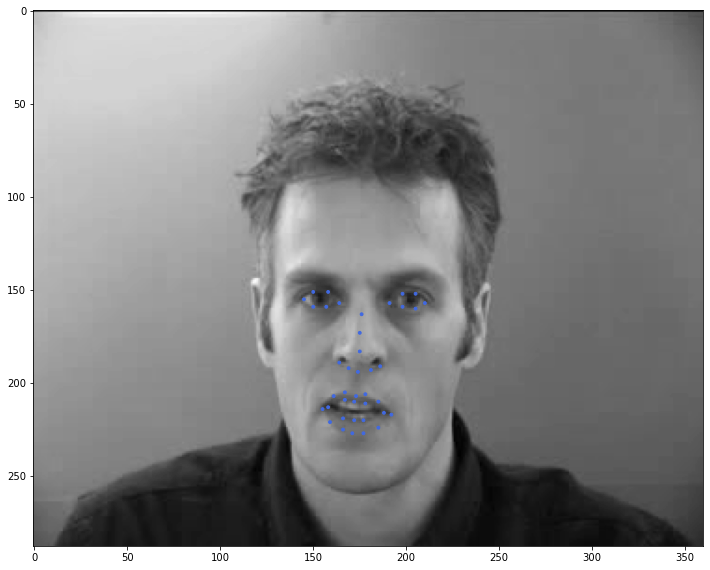

In [11]:
nose, left_eye, right_eye, lips = get_face(frame)